In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv

import pickle
import itertools
import matplotlib.pyplot as plt
import numpy as np

from AutoEncoder import AE, get_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
params = {
    # model
    "linear": False,
    "bias": False,
    "last-linear": False,
    "layers": [784,10,1],

    # training
    "lr": 1e-3,
    "epochs": 40,
    "iterations": 5,
    "optimizer": optim.Adam,
    "criterion": nn.MSELoss(reduction='mean'),
    "hidden_sizes": [[500],[1000],[2000],[1000,500],[2000,1000],[2000,1000,500],[2000,1000,500,300],[2000,1000,500,300,100]],
    "code_lengths": [1,2,3,4,5],
    "batch_sizes": [10,100,1000],
    "activation_types": ["ReLU","linear"],

    # misc
    "verbose": False,
    "device": device,
}

training samples: 60000


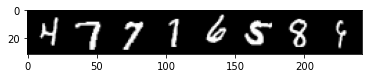

In [4]:
# load and visualize the data

set0 = tv.datasets.MNIST("../MNIST/", 
                         download=True, 
                         train = True,
                         transform = tv.transforms.ToTensor())
loader0 = get_loader(set0, len(set0))

print("training samples: " + str(len(set0)))

def imshow(img):
    npimg = img.numpy()
    plt.imshow((np.transpose(npimg, (1, 2, 0))*255).astype(np.uint8))

dataiter = iter(loader0)
image, _ = dataiter.next()

imshow(tv.utils.make_grid(image[:8]))
plt.show()

In [5]:
activation_type = "ReLU"

print(f"{activation_type}; batch sizes: {params['batch_sizes']}\n")

def print_ranks(activation_type, **params):
    params['linear'] = (activation_type == "linear")
    for code in params['code_lengths']:
        for hidden in params['hidden_sizes']:
            params['layers'] = [784] + hidden + [code]
            shape = hidden+[code]+list(reversed(hidden))+[784]
            print(f"shape: {shape}")
            for batch in params['batch_sizes']:
                name = "AE-{}-Adam-L{}-B{}".format(activation_type, params['layers'][1:], batch)
                
                try:
                    with open("models/"+name+"_activations", "rb") as fp:
                        Phi = pickle.load(fp)
                        print(np.vstack(Phi))
                except: print(f"no file {name}_activations")
                
                print()
                
print_ranks("ReLU", **params)                    

ReLU; batch sizes: [10, 100, 1000]

shape: [500, 1, 500, 784]
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]

[[2 1 1 1]
 [2 1 1 1]
 [2 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]

[[89  1  1  1]
 [72  1  1  1]
 [80  1  1  1]
 [72  1  1  1]
 [75  1  1  1]]

shape: [1000, 1, 1000, 784]
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]

[[2 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]

[[241   1   1   1]
 [221   1   1   1]
 [189   1   1   1]
 [205   1   1   1]
 [236   1   1   1]]

shape: [2000, 1, 2000, 784]
[[  1   1   1   1]
 [  1   1   1   1]
 [250   0   0   0]
 [209   0   0   0]
 [278   0   0   0]]

[[185   0   0   0]
 [178   0   0   0]
 [190   0   0   0]
 [180   0   0   0]
 [173   0   0   0]]

[[168   0   0   0]
 [170   0   0   0]
 [167   0   0   0]
 [172   0   0   0]
 [159   0   0   0]]

shape: [1000, 500, 1, 500, 1000, 784]
[[2 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]

[[5 3 1 1 1 1]
 [7 2 1 1 1 1]
 [3 2 1 1 1 1]
 [3 3 1 1 1 1]
 [2 2 1 1 1 1]

In [2]:
def plot_results(activation_type, b=None, t=None, save=True, **params):
    x = np.arange(0, params['epochs'], 1)
    print(activation_type)
    params['linear'] = (activation_type == "linear")
    for batch in params['batch_sizes']:
        print("Batch size: {}".format(batch))
        fig, axs = plt.subplots(len(params['code_lengths']), len(params['hidden_sizes']),
                                figsize=(len(params['hidden_sizes'])*3,len(params['code_lengths'])*3),
                                sharex='col', sharey='row')
        
        for i, code in enumerate(params['code_lengths']):
            for j, hidden in enumerate(params['hidden_sizes']):
                params['layers'] = [784] + hidden + [code]
                shape = [784] + hidden+[code]+list(reversed(hidden))+[784]
                name = "AE-{}-Adam-L{}-B{}".format(activation_type, params['layers'][1:], batch)
                try:
                    with open("models/"+name+"_history", "rb") as fp:
                        H = pickle.load(fp)
                except: 
                    H = [x*0 for _ in x]
                    print(f"no file {name}_history")
                
                for k, h in enumerate(H):
                    axs[i,j].plot(x, h, label = k)
                    axs[i,j].set_ylim(bottom=b, top=t)
                if i==0:
                    axs[i,j].set_title(str(hidden))

        fig.tight_layout()
        name = "AE-{}-Adam-B{}".format(activation_type, batch)
        if save:
            plt.savefig("plots/AE-" + name + ".png")
        plt.show()
                      
plot_results("ReLU", b=0, t=0.12, save=False, **params)

NameError: name 'params' is not defined

### Conclusions for ReLU
- wider and deeper networks tend to fall into spurious minima

In [7]:
print_ranks("linear", **params)

shape: [500, 1, 500, 784]
no file AE-linear-Adam-L[500, 1]-B10_activations

[[156   1   1   1]
 [141   1   1   1]
 [ 61   1   1   1]
 [ 80   1   1   1]
 [307   1   1   1]]

[[400   1   1   1]
 [384   1   1   1]
 [ 92   1   1   1]
 [400   1   1   1]
 [399   1   1   1]]

shape: [1000, 1, 1000, 784]
no file AE-linear-Adam-L[1000, 1]-B10_activations

[[153   1   1   1]
 [ 33   1   1   1]
 [110   1   1   1]
 [405   1   1   1]
 [156   1   1   1]]

[[476   1   1   1]
 [482   1   1   1]
 [476   1   1   1]
 [476   1   1   1]
 [468   1   1   1]]

shape: [2000, 1, 2000, 784]
no file AE-linear-Adam-L[2000, 1]-B10_activations

[[204   1   1   1]
 [329   1   1   1]
 [170   1   1   1]
 [300   1   1   1]
 [330   1   1   1]]

[[413   1   1   1]
 [510   1   1   1]
 [423   1   1   1]
 [425   1   1   1]
 [427   1   1   1]]

shape: [1000, 500, 1, 500, 1000, 784]
no file AE-linear-Adam-L[1000, 500, 1]-B10_activations

[[131 110   1   1   1   1]
 [ 98   7   1   1   1   1]
 [ 78   9   1   1   1   1]
 [262  42

In [1]:
plot_results("linear", t=0.1, save=False, **params)

NameError: name 'plot_results' is not defined